## Imports

In [53]:
import pyodbc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import geopy.distance as dst
import numpy as np

### Read data

In [43]:
conn_str = (r'DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};'
            r'DBQ=C:\Users\mit\Documents\wildfires\data\sit\2020 SIT DATA.accdb;')
conn = pyodbc.connect(conn_str)
incidents_df = pd.read_sql('select * from SIT209_HISTORY_INCIDENTS', conn)
reports_df = pd.read_sql('select * from SIT209_HISTORY_INCIDENT_209_REPORTS', conn)

lookup = pd.read_sql('select * from SIT209_HISTORY_SIT209_LOOKUP_CODES', conn)

inctyp_lookup = lookup[lookup['CODE_TYPE'] == 'INCIDENT_TYPE']
inctyp_lookup = dict(zip(inctyp_lookup['LUCODES_IDENTIFIER'], inctyp_lookup['CODE_NAME'])) 
incidents_df['INCTYP_IDENTIFIER'] = incidents_df['INCTYP_IDENTIFIER'].astype(str).map(inctyp_lookup)

resources_lookup = lookup[lookup['CODE_TYPE'] == 'RESOURCE_TYPE']
resources_lookup = dict(zip(resources_lookup['LUCODES_IDENTIFIER'], resources_lookup['CODE_NAME']))

resources_df = pd.read_sql('select * from SIT209_HISTORY_INCIDENT_209_RES_UTILIZATIONS', conn)
resources_df = resources_df[resources_df['INC209R_IDENTIFIER'].isin(reports_df['INC209R_IDENTIFIER'])]
resources_df['RESTYP_IDENTIFIER'] = resources_df['RESTYP_IDENTIFIER'].map(resources_lookup)

In [44]:
resources_df['RESTYP_IDENTIFIER'].isna().value_counts()

False    142653
Name: RESTYP_IDENTIFIER, dtype: int64

### Get GACCs, sanity check with plot

In [45]:
nwcg_units_df = pd.read_sql('select * from COMMONDATA_HISTORY_NWCG_UNITS', conn)
# dispatch_offices_df = pd.read_sql('select * from SIT209_HISTORY_DISPATCH_OFFICE_NWCG_UNITS', conn)

nwcg_to_gacc = dict(zip(nwcg_units_df['NWCG_IDENTIFIER'], nwcg_units_df['GACC']))
inc_id_to_gacc = dict(zip(incidents_df['INCIDENT_IDENTIFIER'], 
                          incidents_df['NWCG_PROT_UNIT_IDENTIFIER'].map(nwcg_to_gacc)))

aggs = {key:sum for key in ['RESOURCE_QUANTITY', 'RESOURCE_PERSONNEL']}
resources_df[['RESOURCE_QUANTITY', 'RESOURCE_PERSONNEL']] = resources_df[['RESOURCE_QUANTITY', 'RESOURCE_PERSONNEL']].astype(float)
df = resources_df.groupby(['INC209R_IDENTIFIER', 'RESTYP_IDENTIFIER'], as_index=False).agg(aggs)

cols = ['INC_IDENTIFIER', 'INC209R_IDENTIFIER', 'REPORT_FROM_DATE','POO_LATITUDE', 
        'POO_LONGITUDE', 'CAUSE_IDENTIFIER']

clean_reports = reports_df[cols].copy()
clean_reports['GACC'] = clean_reports['INC_IDENTIFIER'].map(inc_id_to_gacc)

clean_reports = clean_reports.rename(columns={'INC_IDENTIFIER' : 'INCIDENT_IDENTIFIER'})

df = pd.merge(clean_reports, df, on='INC209R_IDENTIFIER', how='right')

wildfires = incidents_df[incidents_df['INCTYP_IDENTIFIER'] == 'Wildfire']['INCIDENT_IDENTIFIER']
df = df[df['INCIDENT_IDENTIFIER'].isin(wildfires)]

df['POO_LONGITUDE'] = df['POO_LONGITUDE'].astype(float)
df['POO_LATITUDE'] = df['POO_LATITUDE'].astype(float)

df_no_dup = df.drop_duplicates('INCIDENT_IDENTIFIER').copy()

In [64]:
df_no_dup

,INCIDENT_IDENTIFIER,INC209R_IDENTIFIER,REPORT_FROM_DATE,POO_LATITUDE,POO_LONGITUDE,CAUSE_IDENTIFIER,GACC,RESTYP_IDENTIFIER,RESOURCE_QUANTITY,RESOURCE_PERSONNEL
0,11683717,11683718,1/8/2020 12:30:00 PM,36.241167,-95.123333,9429898,SAC,Dozer,2.0,2.0
12,11683870,11683871,1/9/2020 5:00:00 PM,33.270833,-103.403611,9429898,SWC,"Engine, Type 6",1.0,3.0
14,11683918,11683919,1/10/2020 4:00:00 PM,28.338333,-81.276944,9429898,SAC,Dozer,1.0,1.0
18,11683965,11683966,1/13/2020 8:15:00 AM,30.996389,-101.334167,9429901,SAC,Dozer,2.0,4.0
28,11684074,11684087,1/9/2020 1:00:00 PM,35.029444,-98.490833,9429901,SAC,Dozer,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...
72839,11980949,11980950,12/24/2020 8:00:00 AM,33.407667,-117.269667,9429901,NaN,Air Attack,2.0,4.0
72852,11980985,11980986,12/26/2020 12:30:00 PM,35.342778,-96.107778,9429898,SAC,"Engine, Type 6",6.0,12.0
72854,11981035,11981036,12/27/2020 6:47:00 PM,33.440000,-98.105556,9429901,SAC,Dozer,2.0,2.0
72857,11981111,11981127,12/28/2020 11:30:00 AM,35.388333,-96.511944,9429898,SAC,"Engine, Type 6",3.0,9.0


<AxesSubplot:xlabel='POO_LONGITUDE', ylabel='POO_LATITUDE'>

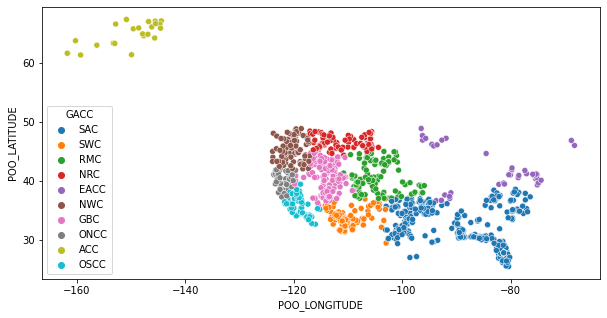

In [46]:
plt.rcParams['figure.figsize'] = (10, 5)
sns.scatterplot(data=df_no_dup, x='POO_LONGITUDE', y='POO_LATITUDE', hue='GACC')

In [47]:
nwcg_units_df

,ID,NWCG_IDENTIFIER,UNITID,NAME,GEOGRAPHIC_AREA,GACC,WILDLAND_ROLE,UNIT_TYPE,DEPARTMENT,PARENT_NWCG_IDENTIFIER,...,NWCGAG_IDENTIFIER,SHORT_NAME,EXPIRATION_DATE,COMMENT_TEXT,DATA_SOURCE_TYPE,NWCG_NWCGAG_IDENTIFIER,FS_REGION_FLAG,URL_TEXT,GACC_IDENTIFIER,CY
0,1,31057726,WAAZVN,"Adam County Fire District 1, Ritzville",NW,NWCC,Other Units,County & Local,WA,None,...,11056549,None,1/29/2008,None,NWCG,11056549,N,None,None,2020
1,2,31057727,WAAWAN,"Adam County Fire District 7, Washtucna",NW,NWCC,Other Units,County & Local,WA,None,...,11056549,None,1/29/2008,None,NWCG,11056549,N,None,None,2020
2,3,31057728,WAAUBN,Auburn Fire Department,NW,NWC,Incident Host Geographic,US County/Local,WA,None,...,11056549,None,None,None,NWCG,11056549,N,None,None,2020
3,4,31057729,WAASON,Asotin Fire Department,NW,NWC,Incident Host Geographic,US County/Local,WA,None,...,11056549,None,None,None,NWCG,11056549,N,None,None,2020
4,5,31057730,WAARNG,Washington Army National Guard,NW,NWC,Incident Host Geographic,US State,WA,31057376,...,11056565,None,None,None,NWCG,11056565,N,None,None,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7396,7397,31063216,CACNH,C & H Sugar Co. FD,CA,ONCC,Other Units,Private,None,None,...,11056578,None,None,None,Local,None,N,None,None,2020
7397,7398,31063217,WYCDX,CDC COUNTIES,RM,RMC,Other Units,County & Local,None,None,...,11056549,None,None,None,Local,None,N,None,None,2020
7398,7399,31063218,CACDFS,CDF - CDF Headquarters Command Center - Sacram...,CA,OSCC,Other Units,State,None,None,...,11056601,None,None,None,Local,None,N,None,None,2020
7399,7400,31063219,WYCPX,CPC COUNTIES,RM,RMC,Other Units,County & Local,None,None,...,11056549,None,None,None,Local,None,N,None,None,2020


### Generate historical assignment data

#### Notes: 
- Type I crew different from "Interagency Hotshot Crew"
- Fake data with respect to rotations

In [48]:
sw = df[df['GACC'] == 'SWC'].copy()
sw_type_1 = sw[sw['RESTYP_IDENTIFIER'] == 'Crew, Type 1'].copy()
sw_type_1['RESOURCE_QUANTITY'] = sw_type_1['RESOURCE_QUANTITY'].astype(float)
sw_type_1['RESOURCE_PERSONNEL'] = sw_type_1['RESOURCE_PERSONNEL'].astype(float)
sw_type_1['ppl_per_crew'] = sw_type_1['RESOURCE_PERSONNEL']/sw_type_1['RESOURCE_QUANTITY']

sw_type_1 = sw_type_1[((sw_type_1['ppl_per_crew'] > 10) & (sw_type_1['ppl_per_crew'] < 30))].copy()

rot = df[~df['GACC'].isin(['SWC', 'SAC'])].copy()

np.random.seed(1)
sample = rot.sample(34).copy()
sample['RESOURCE_QUANTITY'] = [1] * 30 + [2] * 4

sw_type_1 = pd.concat([sw_type_1, sample])

sw_type_1['REPORT_FROM_DATE'] = sw_type_1['REPORT_FROM_DATE'].apply(lambda x: dt.datetime.strptime(x, "%m/%d/%Y %I:%M:%S %p"))
sw_type_1 = sw_type_1.sort_values('REPORT_FROM_DATE')
day_1 = sw_type_1['REPORT_FROM_DATE'].iloc[0].date()
sw_type_1['day'] = sw_type_1['REPORT_FROM_DATE'].apply(lambda x: (x.date() - day_1).days + 1)

sw_type_1['RESOURCE_QUANTITY'] = sw_type_1['RESOURCE_QUANTITY'].astype(float)
sw_type_1['RESOURCE_PERSONNEL'] = sw_type_1['RESOURCE_PERSONNEL'].astype(float)

sw_type_1 = sw_type_1.sort_values('RESOURCE_QUANTITY', ascending=False)
sw_type_1 = sw_type_1.drop_duplicates(['INCIDENT_IDENTIFIER', 'day'])

cols = ['INCIDENT_IDENTIFIER', 'POO_LATITUDE', 'POO_LONGITUDE', 'day', 'RESOURCE_QUANTITY', 'GACC']
new_cols = ['fire','lat', 'lon', 'day', 'demand', 'outside_gacc']
demands = sw_type_1[cols].rename(columns=dict(zip(cols, new_cols))).copy()
demands['demand'] = demands['demand'].astype(int)
demands['outside_gacc'] = demands['outside_gacc'] != 'SWC'
demands = demands.sort_values('day').reset_index(drop=True)

fire_ids = demands[['fire']].drop_duplicates().reset_index(drop=True).reset_index()
fire_ids = dict(zip(fire_ids['fire'], fire_ids['index'] + 1))

demands['fire_id'] = demands['fire'].map(fire_ids)

demands 

,fire,lat,lon,day,demand,outside_gacc,fire_id
0,11709158,33.296389,-111.251944,1,1,False,1
1,11702287,33.361640,-109.088600,19,1,False,2
2,11704780,36.919722,-106.889167,20,2,False,3
3,11704780,36.919850,-106.889200,21,2,False,3
4,11704780,36.919850,-106.889200,22,2,False,3
...,...,...,...,...,...,...,...
481,11970319,36.264230,-105.339600,186,1,False,103
482,11958269,34.274840,-112.418900,186,1,False,102
483,11979237,34.147222,-112.117778,187,1,False,106
484,11979237,34.147222,-112.117778,188,1,False,106


In [87]:
crews = df[df['RESTYP_IDENTIFIER'] == 'Crew, Type 1'].copy()
crews = crews.groupby('INCIDENT_IDENTIFIER', as_index=False).agg({'RESOURCE_QUANTITY' : sum})
crews = crews.sort_values('RESOURCE_QUANTITY', ascending=False)
biggest_fires = crews['INCIDENT_IDENTIFIER'].iloc[:100]

In [108]:
big_fires = df[df['INCIDENT_IDENTIFIER'].isin(biggest_fires)].drop_duplicates('INCIDENT_IDENTIFIER')

big_fires['REPORT_FROM_DATE'] = big_fires['REPORT_FROM_DATE'].apply(lambda x: 
                                                                    dt.datetime.strptime(x, "%m/%d/%Y %I:%M:%S %p"))

cols = ['INCIDENT_IDENTIFIER', 'POO_LATITUDE', 'POO_LONGITUDE']
new_cols = ['fire','lat', 'lon']

big_fires = big_fires.sort_values('REPORT_FROM_DATE').rename(columns=dict(zip(cols, new_cols)))
big_fires.iloc[:50]

,fire,INC209R_IDENTIFIER,REPORT_FROM_DATE,lat,lon,CAUSE_IDENTIFIER,GACC,RESTYP_IDENTIFIER,RESOURCE_QUANTITY,RESOURCE_PERSONNEL
4993,11721009,11721022,2020-05-30 21:00:00,33.413889,-111.133889,9429899,SWC,Air Attack Platform,1.0,0.0
7127,11730528,11730549,2020-06-06 11:15:00,33.415000,-109.311667,9429899,SWC,Air Attack Platform,1.0,2.0
7823,11733300,11733369,2020-06-06 15:00:00,32.951667,-108.280278,9429901,SWC,"Engine, Type 3",1.0,7.0
8168,11734621,11734660,2020-06-06 20:00:00,38.470556,-122.048056,9429901,ONCC,"Crew, Type 1",10.0,150.0
5747,11724989,11724990,2020-06-08 17:30:00,36.627500,-112.349444,9429901,SWC,"Crew, Type 1",4.0,80.0
3822,11713907,11714092,2020-06-10 18:30:00,34.462500,-118.772500,9429901,OSCC,"Crew, Type 1",1.0,20.0
5115,11721706,11721876,2020-06-13 16:00:00,33.625700,-111.562000,9429898,SWC,Air Attack Platform,2.0,1.0
7534,11731957,11732050,2020-06-14 13:45:00,37.277778,-108.255833,9429899,RMC,Air Attack Platform,2.0,0.0
4453,11717227,11717356,2020-06-15 17:00:00,35.179611,-120.697172,9429901,OSCC,"Crew, Type 1",6.0,80.0
4201,11716185,11716186,2020-06-16 20:00:00,36.380556,-121.001389,9429901,OSCC,"Crew, Type 1",2.0,15.0


### Plot showing daily crew demands

<AxesSubplot:xlabel='day', ylabel='demand'>

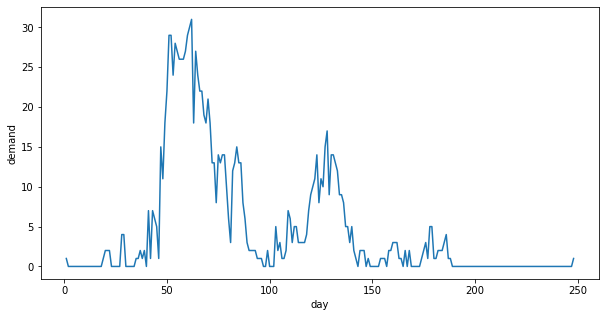

In [49]:
daily_demands = demands.groupby('day', as_index=False).agg({'demand' : sum})
fill = pd.DataFrame({'day' : range(1, daily_demands['day'].max() + 1), 'demand' : 0})
daily_demands = pd.concat([daily_demands, fill]).drop_duplicates('day').sort_values('day').reset_index()
sns.lineplot(data=daily_demands, x='day', y='demand')

### Generate some fire-to-fire distances (as the crow flies)

In [54]:
fires = demands.drop_duplicates('fire_id').sort_values('fire_id')
locs = fires[['lat', 'lon']].to_numpy()

n = locs.shape[0]

dists = np.zeros((n, n))

for i in range(n):
    for j in range(n):
        if i < j:
            dists[i, j] = dst.distance(locs[i], locs[j]).miles
            dists[j, i] = dists[i, j]

In [100]:
locs = big_fires[['lat', 'lon']].to_numpy()

n = locs.shape[0]

dists = np.zeros((n, n))

for i in range(n):
    for j in range(n):
        if i < j:
            dists[i, j] = dst.distance(locs[i], locs[j]).miles
            dists[j, i] = dists[i, j]

<AxesSubplot:ylabel='Count'>

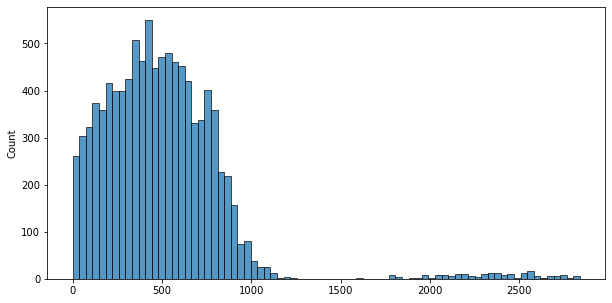

In [101]:
sns.histplot(data=np.ravel(dists))

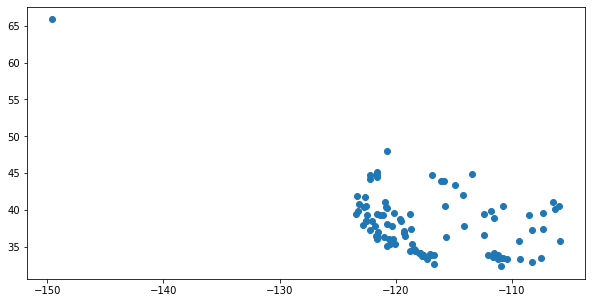

In [102]:
plt.scatter(big_fires['lon'], big_fires['lat'])

### Invent some crew home base locations 

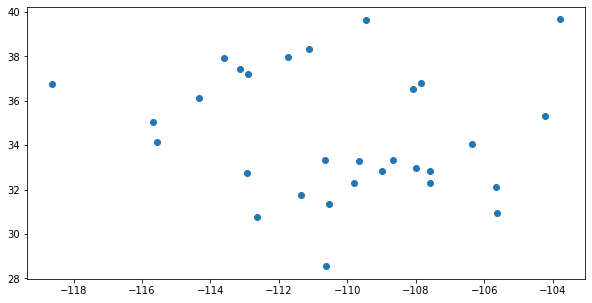

In [56]:
k=30

np.random.seed(123)
lats = demands['lat'].mean() + np.random.normal(size=k) * demands['lat'].std()
lons = demands['lon'].mean() + np.random.normal(size=k) * demands['lon'].std()

plt.scatter(lons, lats)

<AxesSubplot:ylabel='Count'>

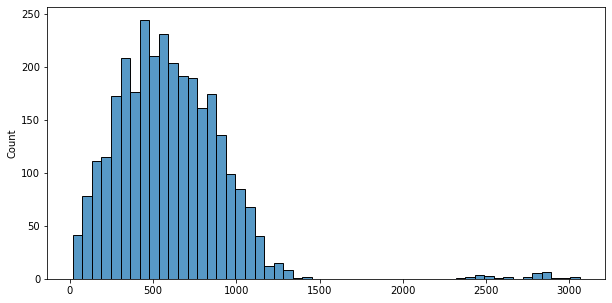

In [103]:
sim_bases = pd.DataFrame({'lat' : lats, 'lon' : lons})

base_locs = sim_bases.to_numpy()

m = base_locs.shape[0]
base_fire_dists = np.zeros((m, n))

for i in range(m):
    for j in range(n):
        base_fire_dists[i, j] = dst.distance(base_locs[i], locs[j]).miles
        
sns.histplot(data=np.ravel(base_fire_dists))

In [104]:
path = r'C:\Users\mit\Downloads\Data for Jacob May 4 2022\home_bases.xlsx'
true_base_locations = pd.read_excel(path, engine="openpyxl", sheet_name=None)['Addresses 2022']

rename_cols = {'Longitude' : 'lat', 'Latitude': 'lon'}
true_base_locations = true_base_locations.rename(columns=rename_cols)[rename_cols.values()]
true_base_locations = true_base_locations[true_base_locations['lat'].notna()]

true_base_locations

,lat,lon
0,64.828516,-147.697589
1,64.828516,-147.697589
2,61.605294,-149.094236
3,41.342956,-88.132165
4,40.486953,-111.899479
...,...,...
112,35.654562,-105.979498
113,32.789602,-108.244006
114,33.350096,-105.676056
115,35.069960,-108.845830


<AxesSubplot:ylabel='Count'>

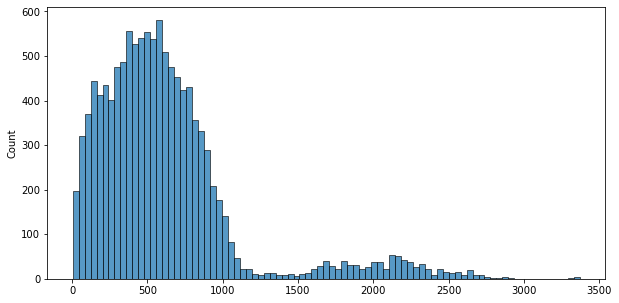

In [105]:
base_locs = true_base_locations.to_numpy()

m = base_locs.shape[0]
base_fire_dists = np.zeros((m, n))

for i in range(m):
    for j in range(n):
        base_fire_dists[i, j] = dst.distance(base_locs[i], locs[j]).miles
        
sns.histplot(data=np.ravel(base_fire_dists))

## Save

In [109]:
import os
path = 'data/processed/big_fires'
if not os.path.isdir(path):
    os.mkdir(path)
np.savetxt(f'{path}/base_fire_distances.csv', base_fire_dists, delimiter=',')
np.savetxt(f'{path}/fire_distances.csv', dists, delimiter=',')
# demands[['day', 'fire_id', 'demand', 'outside_gacc']].to_csv('data/processed/demands.csv', index=False)

### CHECK "GENERAL_FIRE_BEHAVIOR" FROM REPORTS AS A PREDICTOR
### CAUSE_IDENTIFIER INCIDENT_DF

In [19]:
conn_str = (r'DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};'
            r'DBQ=C:\Users\mit\Documents\wildfires\data\sit\databases\2019 SIT DATA.accdb;')
conn = pyodbc.connect(conn_str)
incidents_df = pd.read_sql('select * from SIT209_HISTORY_INCIDENTS', conn)
reports_df = pd.read_sql('select * from SIT209_HISTORY_INCIDENT_209_REPORTS', conn)

lookup = pd.read_sql('select * from SIT209_HISTORY_SIT209_LOOKUP_CODES', conn)

inctyp_lookup = lookup[lookup['CODE_TYPE'] == 'INCIDENT_TYPE']
inctyp_lookup = dict(zip(inctyp_lookup['LUCODES_IDENTIFIER'], inctyp_lookup['CODE_NAME'])) 
incidents_df['INCTYP_IDENTIFIER'] = incidents_df['INCTYP_IDENTIFIER'].astype(str).map(inctyp_lookup)

resources_lookup = lookup[lookup['CODE_TYPE'] == 'RESOURCE_TYPE']
resources_lookup = dict(zip(resources_lookup['LUCODES_IDENTIFIER'], resources_lookup['CODE_NAME']))

resources_df = pd.read_sql('select * from SIT209_HISTORY_INCIDENT_209_RES_UTILIZATIONS', conn)
resources_df = resources_df[resources_df['INC209R_IDENTIFIER'].isin(reports_df['INC209R_IDENTIFIER'])]
resources_df['RESTYP_IDENTIFIER'] = resources_df['RESTYP_IDENTIFIER'].map(resources_lookup)

In [23]:
reports_df

,ID,INC209R_IDENTIFIER,INC_IDENTIFIER,DONWCGU_PROT_UNIT_IDENTIFIER,REPORT_FROM_DATE,REPORT_TO_DATE,STATUS,INCIDENT_DESCRIPTION,INCIDENT_COMMANDERS_NARR,CURR_INCIDENT_AREA,...,SECNDRY_FUEL_MODEL_IDENTIFIER,ADDNTL_FUEL_MODEL_IDENTIFIER,GEN_FIRE_BEHAVIOR_IDENTIFIER,FIRE_BEHAVIOR_1_IDENTIFIER,FIRE_BEHAVIOR_2_IDENTIFIER,FIRE_BEHAVIOR_3_IDENTIFIER,ROAD_CLOSURE_FLAG,AREA_CLOSURE_FLAG,TRAIL_CLOSURE_FLAG,UNIFIED_COMMAND_FLAG
0,1,10670129.0,10670128.0,9337398.0,2019-02-26 04:00:00,2019-02-26 07:00:00,U,Wild fire,Stephen Hammond\nKentucky Division of Forestry \n,154.0,...,9352037,9352042,9352419,9352426,9352427,9352428,N,N,N,N
1,2,10670139.0,10670128.0,9337398.0,2019-02-26 07:00:00,2019-02-27 07:00:00,F,Wild fire,Stephen Hammond\nKentucky Division of Forestry \n,154.0,...,9352037,9352035,9352420,9352437,9352425,None,N,N,N,N
2,3,10670212.0,10670211.0,9337753.0,2019-01-20 12:00:00,2019-01-20 15:30:00,I,None,RONNIE OUIMETTE,500.0,...,None,None,9352419,None,None,None,N,N,N,N
3,4,10670222.0,10670211.0,9337753.0,2019-01-22 06:00:00,2019-01-22 15:00:00,F,None,RONNIE OUIMETTE,723.0,...,None,None,9352421,None,None,None,N,N,N,N
4,5,10670243.0,10670242.0,9338659.0,2019-04-10 15:10:00,2019-04-10 20:41:00,I,None,Chris Woods/USFS,250.0,...,None,None,9352419,None,None,None,N,N,N,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7031,7032,10789161.0,10788219.0,9337460.0,2019-08-08 19:00:00,2019-08-09 17:00:00,U,None,Joe Sampson ICT2,429.0,...,9352034,None,9352421,9352429,None,None,Y,Y,Y,N
7032,7033,10790330.0,10790259.0,9338267.0,2019-07-29 21:00:00,2019-07-30 18:00:00,F,None,Jackson Spooner,151.0,...,9352037,None,9352421,None,None,None,N,N,N,N
7033,7034,10790344.0,10790259.0,9338267.0,2019-07-28 21:15:00,2019-07-29 19:00:00,U,None,Jackson Spooner,151.0,...,9352037,None,9352421,9352437,None,None,N,N,N,N
7034,7035,10790360.0,10790259.0,9338267.0,2019-07-27 20:15:00,2019-07-28 21:00:00,U,None,Jackson Spooner,151.0,...,9352037,None,9352421,9352429,9352437,None,N,N,N,N


In [22]:
resources_df = pd.read_sql('select * from SIT209_HISTORY_INCIDENT_209_RES_UTILIZATIONS', conn)
resources_df

,ID,INC209RU_IDENTIFIER,INC209R_IDENTIFIER,NWCGAG_IDENTIFIER,RESTYP_IDENTIFIER,RESOURCE_QUANTITY,RESOURCE_PERSONNEL
0,1,284152.0,284143.0,22360.0,9905.0,1,2.0
1,2,282011.0,282005.0,1000085.0,9899.0,2,2.0
2,3,282012.0,282005.0,1000085.0,9924.0,None,0.0
3,4,282013.0,282005.0,1000085.0,9905.0,3,3.0
4,5,284153.0,284143.0,22360.0,9924.0,None,0.0
...,...,...,...,...,...,...,...
229761,229762,4388080.0,4388060.0,1007676.0,2990114.0,None,8.0
229762,229763,4388081.0,4388060.0,1007578.0,2990114.0,None,0.0
229763,229764,4388082.0,4388060.0,1007571.0,2990114.0,None,4.0
229764,229765,4388083.0,4388060.0,1007554.0,2990114.0,None,10.0
